In [1]:
import sys

sys.path.append('../')

import argparse
import numpy as np
import stheno.torch as stheno
import torch
import matplotlib.pyplot as plt
import os

import cnp.data

from cnp.experiment import (
    report_loss,
    generate_root,
    WorkingDirectory,
    save_checkpoint
)

from cnp.cnp import StandardGNP, StandardAGNP, StandardConvGNP, StandardFullyConnectedTEGNP
from cnp.cov import (
    InnerProdCov,
    KvvCov,
    MeanFieldCov,
    AddHomoNoise,
    AddHeteroNoise,
    AddNoNoise
)

from cnp.utils import device
from torch.distributions import MultivariateNormal

In [2]:
def validate(data, model, report_freq=None, std_error=False):
    """
    Compute the validation loss.
    """
    
    model.eval()
    likelihoods = []
    
    with torch.no_grad():
        for step, task in enumerate(data):

            mean, cov, cov_plus_noise = model(task['x_context'].float(),
                                              task['y_context'].float(),
                                              task['x_target'].float())

            dist = MultivariateNormal(loc=mean[:, :, 0],
                                      covariance_matrix=cov_plus_noise)
            obj = - dist.log_prob(task['y_target'][:, :, 0]).sum()

            likelihoods.append(obj.item())

    likelihoods = np.array(likelihoods)
    avg_ll = likelihoods.mean()
    
    return avg_ll, task


def train(data, model, opt, report_freq):
    """Perform a training epoch."""
    
    model.train()
    loss = 0.
    
    for step, task in enumerate(data):
        
        num_tasks = task['x_context'].shape[0]
        
        mean, cov, cov_plus_noise = model(task['x_context'].float(),
                                          task['y_context'].float(),
                                          task['x_target'].float())

        dist = MultivariateNormal(loc=mean[:, :, 0],
                                  covariance_matrix=cov_plus_noise)
        loss = loss - dist.log_prob(task['y_target'][:, :, 0]).mean()

    mean_loss = loss  / (step + 1)
    
    # Optimization
    mean_loss.backward()
    opt.step()
    
#     for parameter in model.decoder.deepset.element_network.parameters():
#         print(parameter.shape)
#         print(parameter.grad)
#         input('')
        
#     print('Done')
        
        
    opt.zero_grad()

    # Track training progress
#     avg_loss = loss.detach().cpu().numpy()
    report_loss('Training', mean_loss, step + 1, report_freq)

    return mean_loss

In [3]:
num_train_tasks = 16
num_valid_tasks = 1
learning_rate = 1e-3
epochs = 1000
num_basis_dim = 512

In [4]:
kernel = stheno.EQ().stretch(1.0)
gp = stheno.GP(kernel)
gen = cnp.data.GPGenerator(kernel=kernel, num_tasks=num_train_tasks, batch_size=32)
gen_val = cnp.data.GPGenerator(kernel=kernel, num_tasks=num_valid_tasks, batch_size=32)

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 1/1000
Training        epoch 0: 2.586e+01
Validation      epoch 0: 7.422e+02


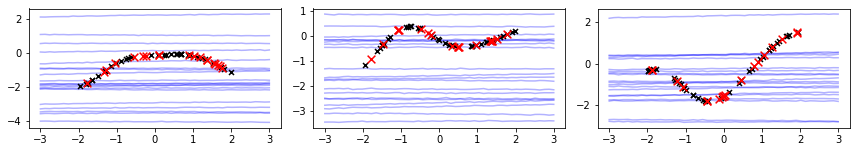

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 11/1000
Training        epoch 10: 2.768e+01
Validation      epoch 10: 9.375e+02


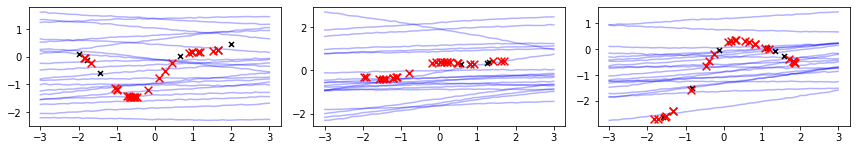

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 21/1000
Training        epoch 20: 2.288e+01
Validation      epoch 20: 7.355e+02


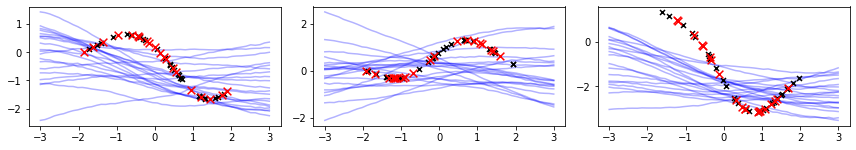

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 31/1000
Training        epoch 30: 2.326e+01
Validation      epoch 30: 6.287e+02


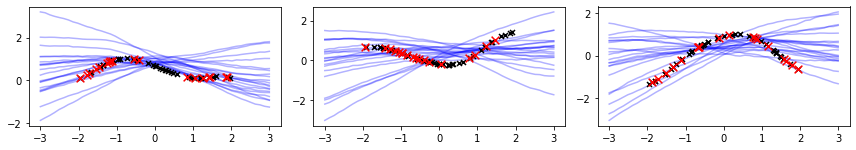

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 41/1000
Training        epoch 40: 2.246e+01
Validation      epoch 40: 1.574e+03


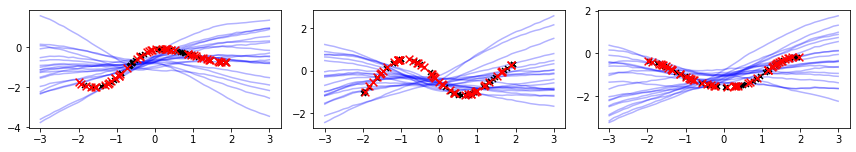

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 51/1000
Training        epoch 50: 3.089e+01
Validation      epoch 50: 1.679e+02


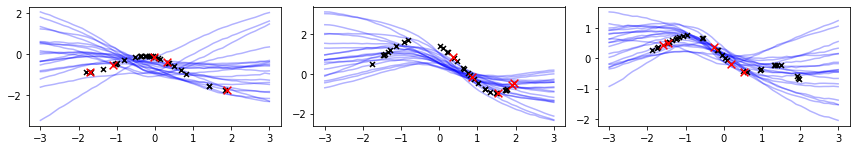

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 61/1000
Training        epoch 60: 2.125e+01
Validation      epoch 60: 6.620e+02


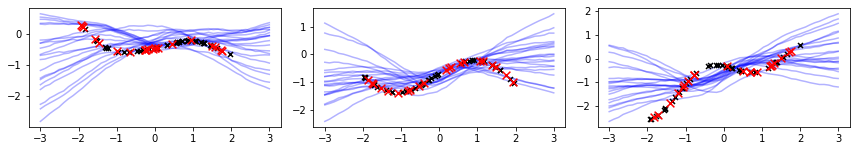

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 71/1000
Training        epoch 70: 2.545e+01
Validation      epoch 70: 4.860e+02


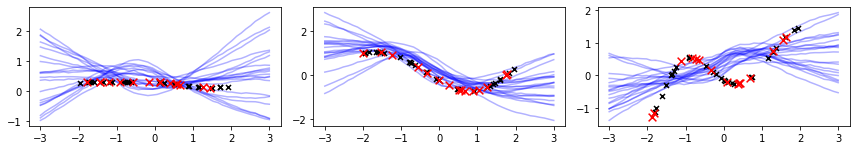

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 81/1000
Training        epoch 80: 2.799e+01
Validation      epoch 80: 9.581e+01


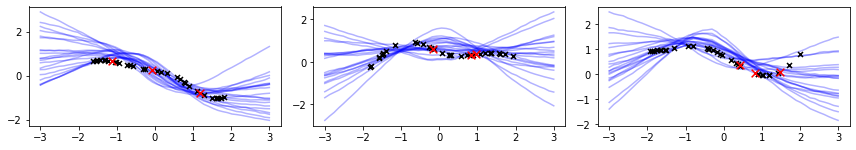

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 91/1000
Training        epoch 90: 2.331e+01
Validation      epoch 90: 1.298e+03


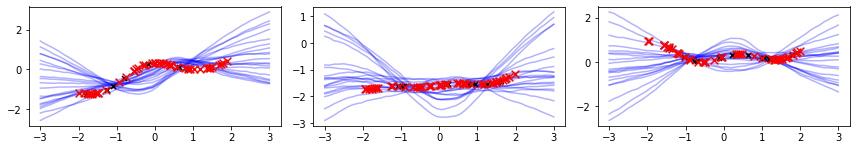

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 101/1000
Training        epoch 100: 2.217e+01
Validation      epoch 100: 2.700e+02


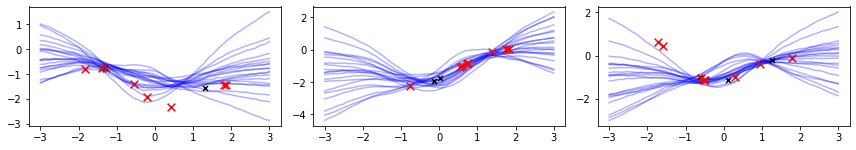

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 111/1000
Training        epoch 110: 2.252e+01
Validation      epoch 110: 4.518e+02


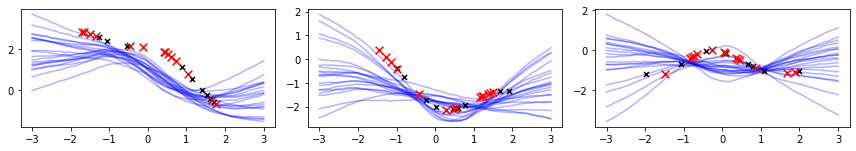

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 121/1000
Training        epoch 120: 2.175e+01
Validation      epoch 120: 6.669e+02


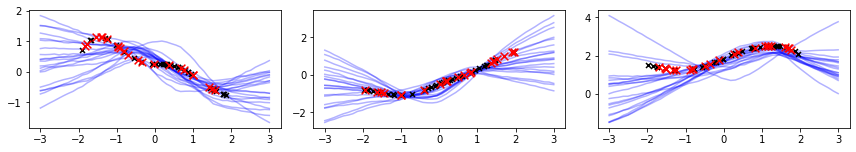

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 131/1000
Training        epoch 130: 2.383e+01
Validation      epoch 130: 1.255e+03


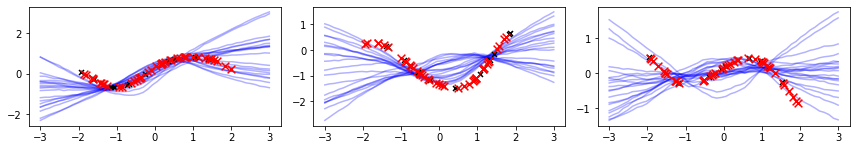

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 141/1000
Training        epoch 140: 2.220e+01
Validation      epoch 140: 1.318e+03


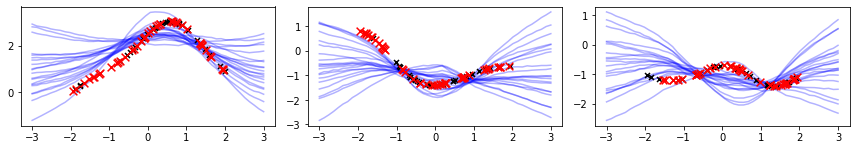

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 151/1000
Training        epoch 150: 3.307e+01
Validation      epoch 150: 4.237e+02


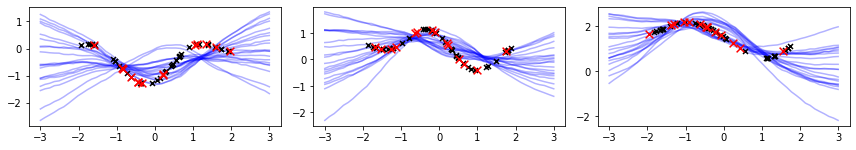

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 161/1000
Training        epoch 160: 1.540e+01
Validation      epoch 160: 1.166e+03


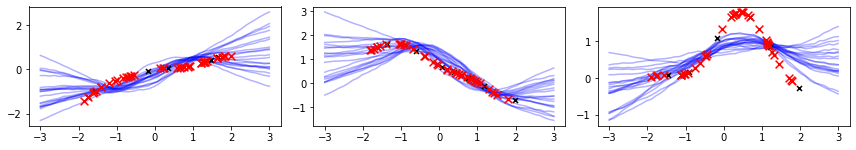

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 171/1000
Training        epoch 170: 2.285e+01
Validation      epoch 170: 4.838e+02


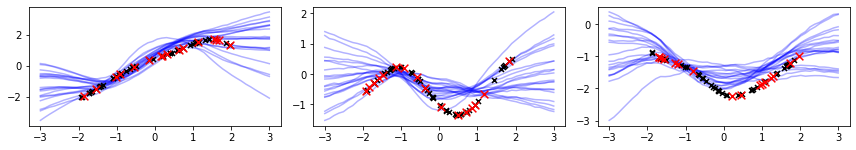

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 181/1000
Training        epoch 180: 2.292e+01
Validation      epoch 180: 2.083e+02


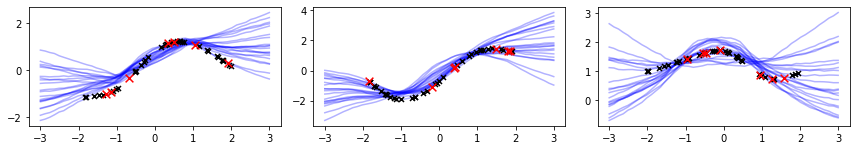

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 191/1000
Training        epoch 190: 2.643e+01
Validation      epoch 190: 3.938e+02


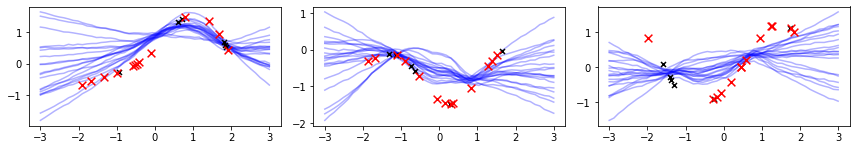

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 201/1000
Training        epoch 200: 2.822e+01
Validation      epoch 200: 1.226e+02


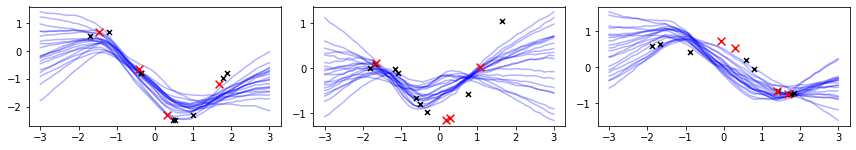

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 211/1000
Training        epoch 210: 2.029e+01
Validation      epoch 210: 2.311e+02


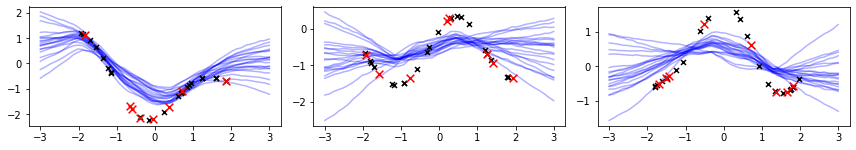

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 221/1000
Training        epoch 220: 2.727e+01
Validation      epoch 220: 1.719e+02


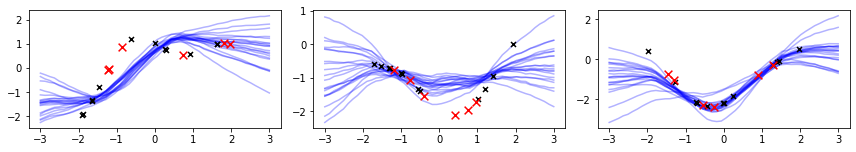

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 231/1000
Training        epoch 230: 2.831e+01
Validation      epoch 230: 4.052e+02


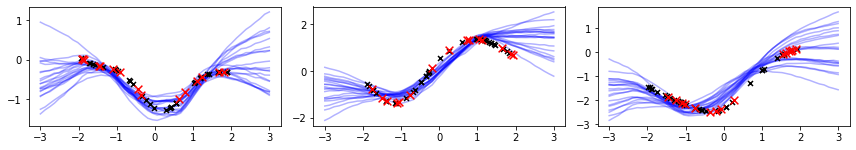

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 241/1000
Training        epoch 240: 2.410e+01
Validation      epoch 240: 8.285e+01


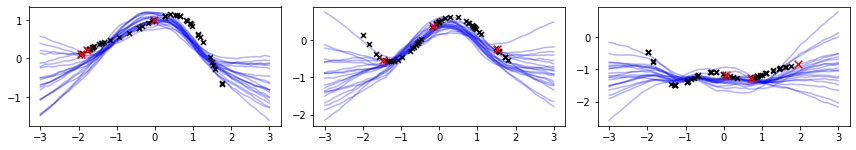

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 251/1000
Training        epoch 250: 2.406e+01
Validation      epoch 250: 8.908e+02


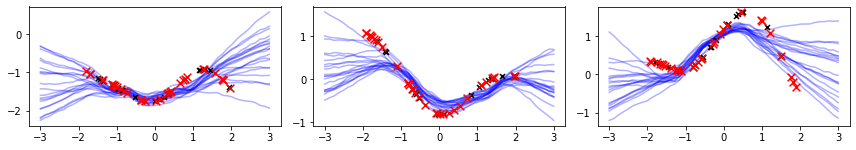

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 261/1000
Training        epoch 260: 2.399e+01
Validation      epoch 260: 4.023e+02


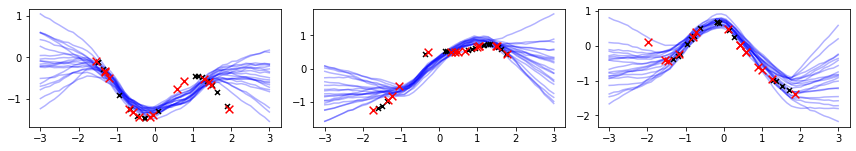

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 271/1000
Training        epoch 270: 2.045e+01
Validation      epoch 270: 1.879e+02


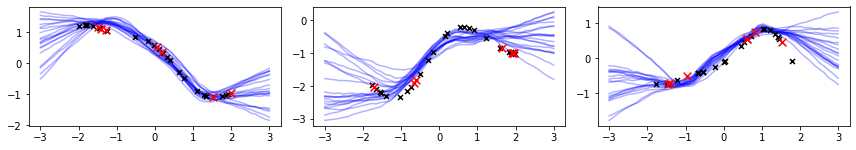

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 281/1000
Training        epoch 280: 2.435e+01
Validation      epoch 280: 8.915e+02


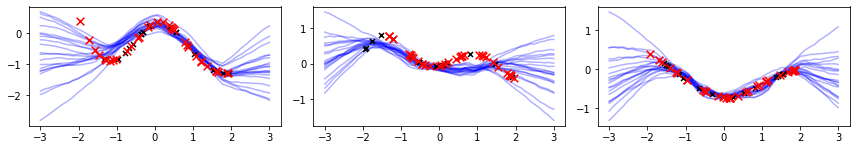

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 291/1000
Training        epoch 290: 2.468e+01
Validation      epoch 290: 8.850e+02


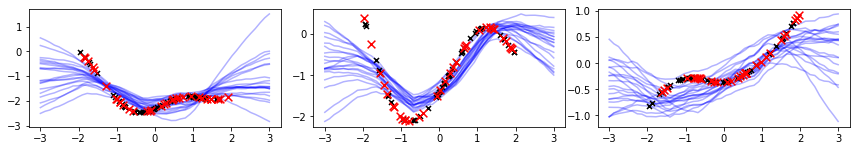

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 301/1000
Training        epoch 300: 2.338e+01
Validation      epoch 300: 1.247e+03


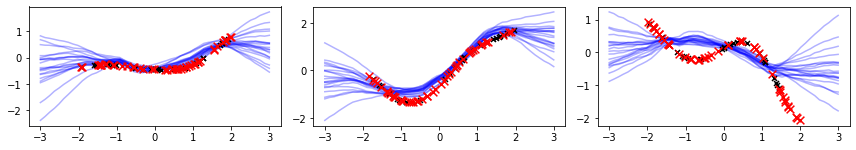

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 311/1000
Training        epoch 310: 2.606e+01
Validation      epoch 310: 3.891e+02


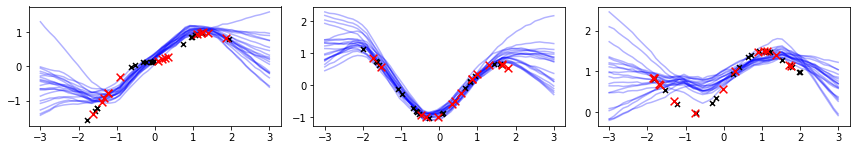

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 321/1000
Training        epoch 320: 2.088e+01
Validation      epoch 320: 2.302e+02


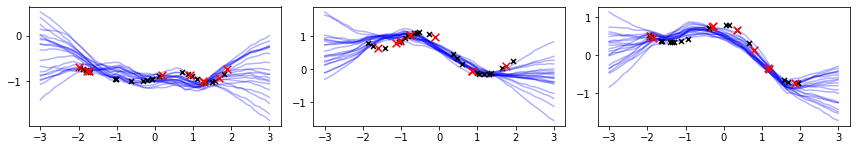

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 331/1000
Training        epoch 330: 2.049e+01
Validation      epoch 330: 2.332e+02


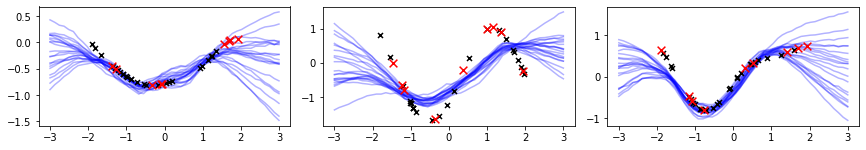

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 341/1000
Training        epoch 340: 2.327e+01
Validation      epoch 340: 8.819e+02


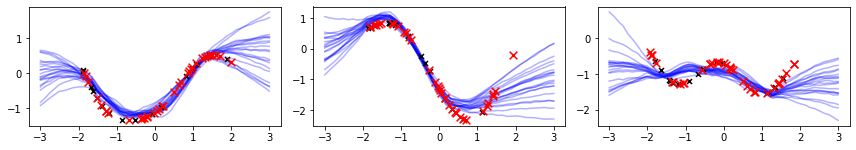

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 351/1000
Training        epoch 350: 2.272e+01
Validation      epoch 350: 5.676e+02


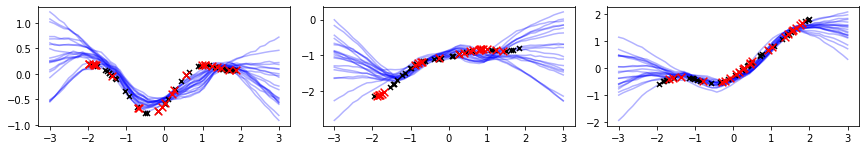

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 361/1000
Training        epoch 360: 2.369e+01
Validation      epoch 360: 2.606e+02


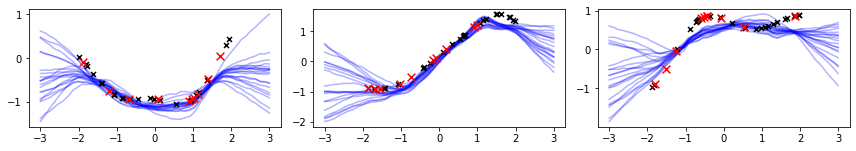

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 371/1000
Training        epoch 370: 1.822e+01
Validation      epoch 370: 9.959e+02


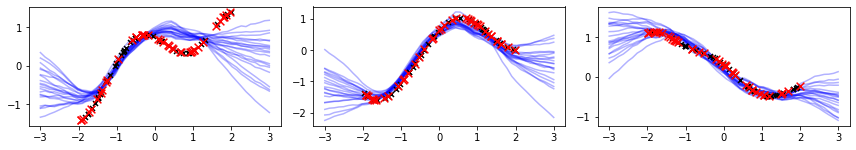

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 381/1000
Training        epoch 380: 2.430e+01
Validation      epoch 380: 6.385e+02


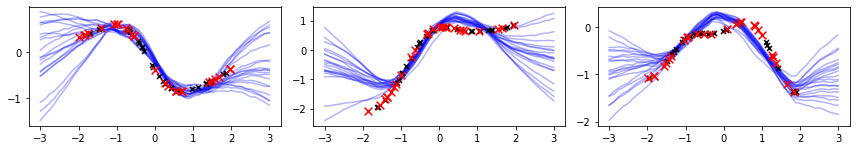

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 391/1000
Training        epoch 390: 1.642e+01
Validation      epoch 390: 1.450e+02


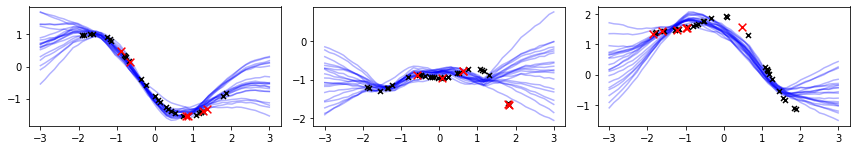

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 401/1000
Training        epoch 400: 2.095e+01
Validation      epoch 400: 7.209e+02


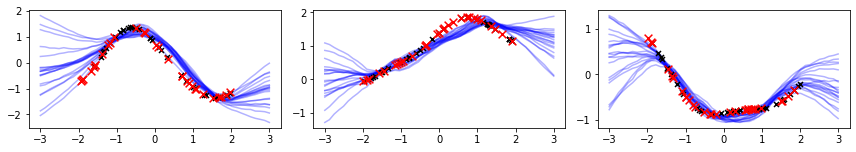

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 411/1000
Training        epoch 410: 2.017e+01
Validation      epoch 410: 3.612e+02


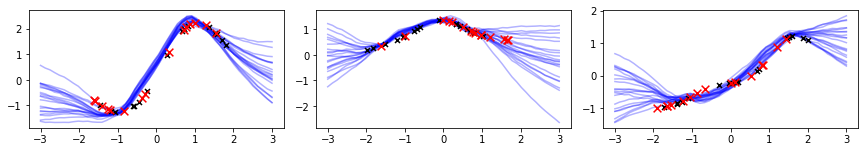

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 421/1000
Training        epoch 420: 2.180e+01
Validation      epoch 420: 5.165e+02


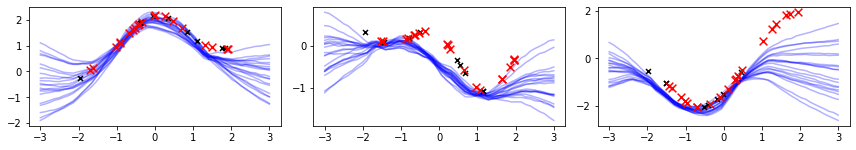

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 431/1000
Training        epoch 430: 1.533e+01
Validation      epoch 430: 5.325e+02


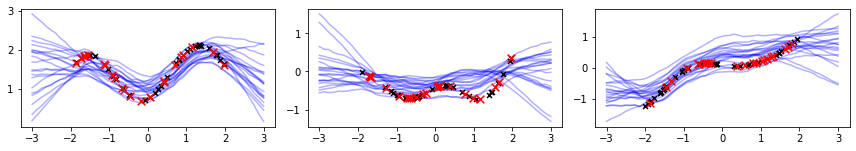

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 441/1000
Training        epoch 440: 2.123e+01
Validation      epoch 440: 1.046e+03


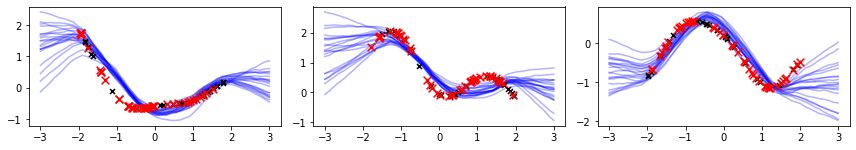

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 451/1000
Training        epoch 450: 2.398e+01
Validation      epoch 450: 4.185e+02


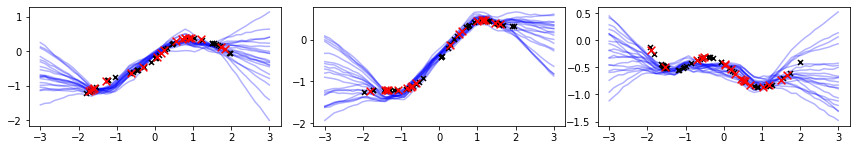

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 461/1000
Training        epoch 460: 1.888e+01
Validation      epoch 460: 9.387e+02


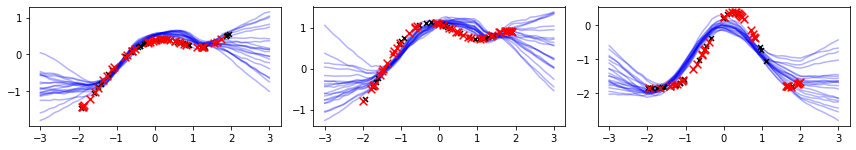

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 471/1000
Training        epoch 470: 2.350e+01
Validation      epoch 470: 6.899e+02


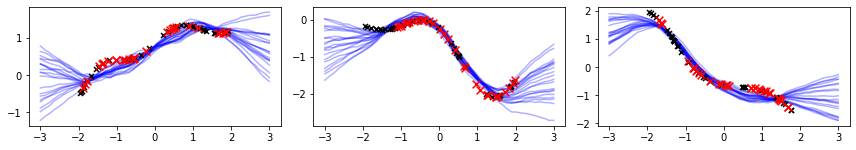

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 481/1000
Training        epoch 480: 1.813e+01
Validation      epoch 480: 2.559e+02


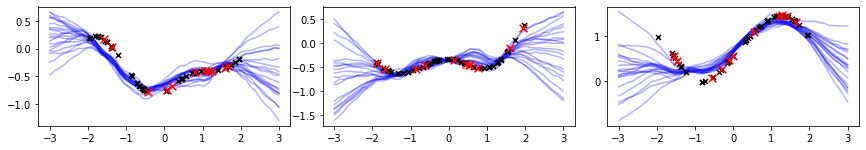

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 491/1000
Training        epoch 490: 2.052e+01
Validation      epoch 490: 9.007e+02


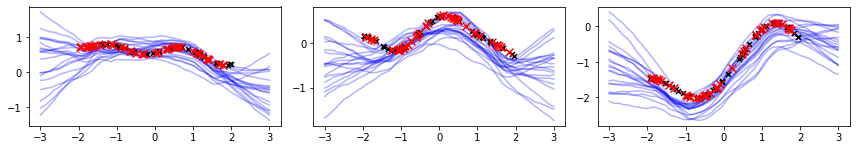

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 501/1000
Training        epoch 500: 1.471e+01
Validation      epoch 500: 6.035e+02


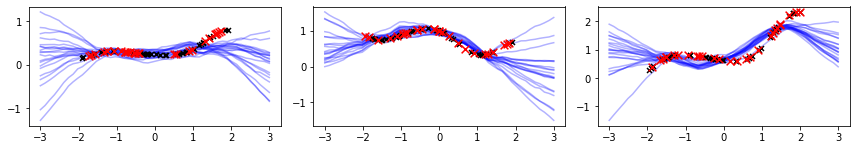

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 511/1000
Training        epoch 510: 2.067e+01
Validation      epoch 510: 3.492e+02


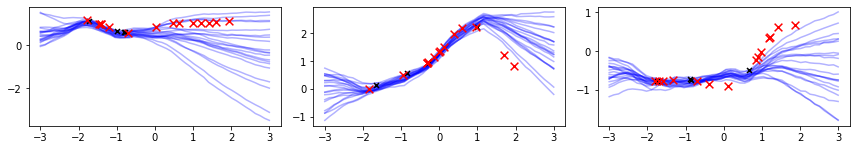

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 521/1000
Training        epoch 520: 1.873e+01
Validation      epoch 520: 8.652e+02


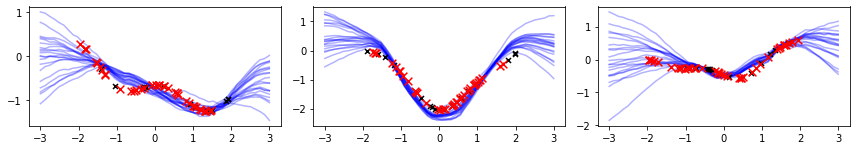

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 531/1000
Training        epoch 530: 1.688e+01
Validation      epoch 530: 4.389e+02


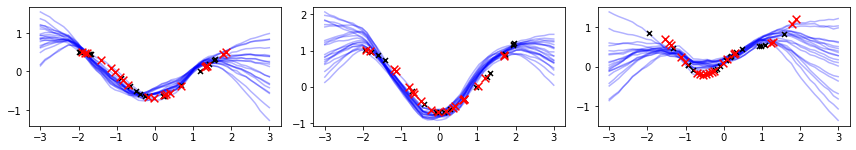

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 541/1000
Training        epoch 540: 2.080e+01
Validation      epoch 540: 1.039e+03


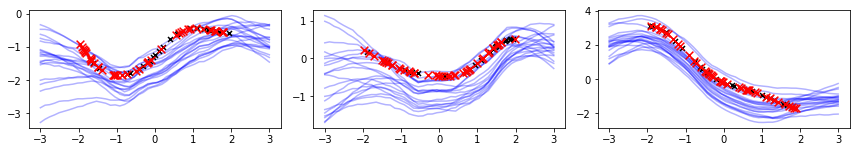

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 551/1000
Training        epoch 550: 1.866e+01
Validation      epoch 550: 5.417e+02


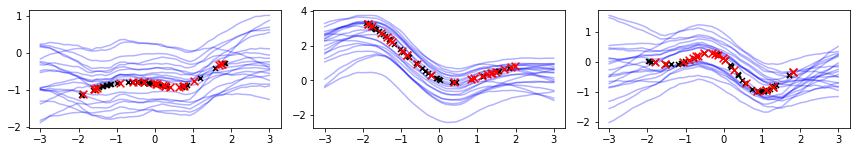

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 561/1000
Training        epoch 560: 1.615e+01
Validation      epoch 560: 1.044e+03


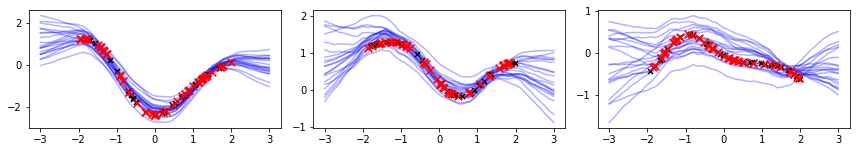

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 571/1000
Training        epoch 570: 2.115e+01
Validation      epoch 570: 3.350e+02


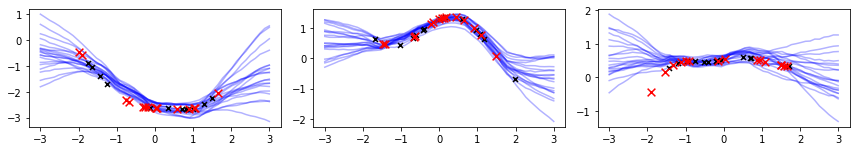

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 581/1000
Training        epoch 580: 2.011e+01
Validation      epoch 580: 1.910e+02


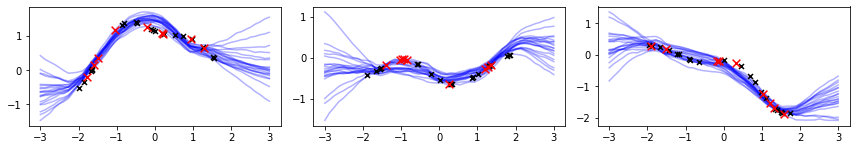

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 591/1000
Training        epoch 590: 1.653e+01
Validation      epoch 590: 9.855e+02


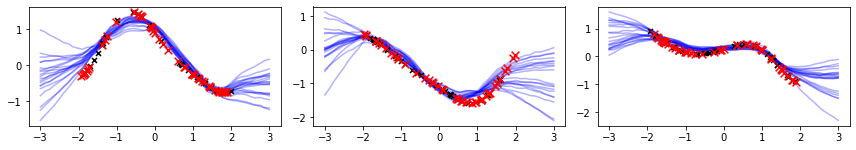

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 601/1000
Training        epoch 600: 1.780e+01
Validation      epoch 600: 7.831e+02


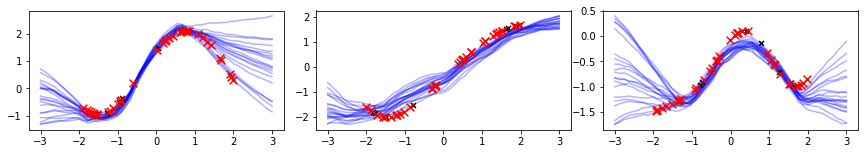

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 611/1000
Training        epoch 610: 1.524e+01
Validation      epoch 610: 4.643e+02


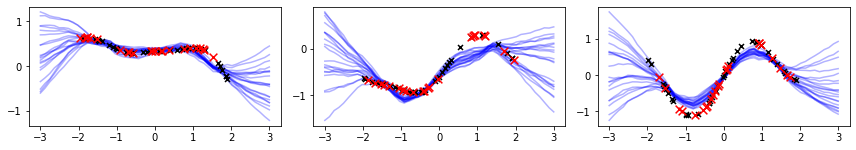

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 621/1000
Training        epoch 620: 1.452e+01
Validation      epoch 620: 7.797e+02


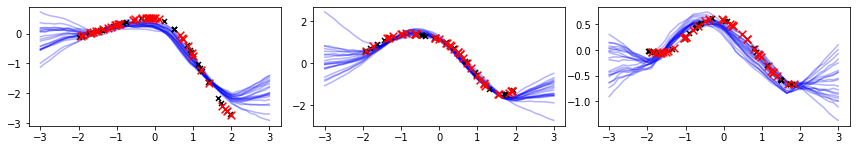

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 631/1000
Training        epoch 630: 1.939e+01
Validation      epoch 630: 7.657e+02


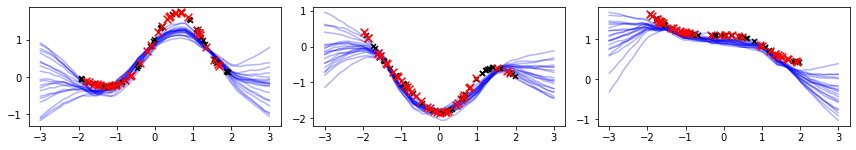

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 641/1000
Training        epoch 640: 1.482e+01
Validation      epoch 640: 2.258e+02


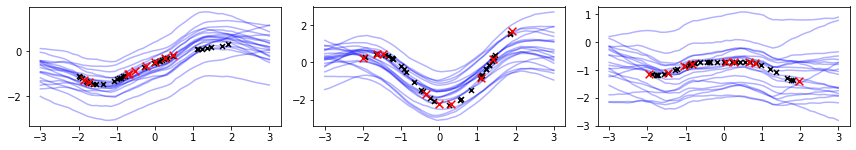

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 651/1000
Training        epoch 650: 1.663e+01
Validation      epoch 650: 2.176e+02


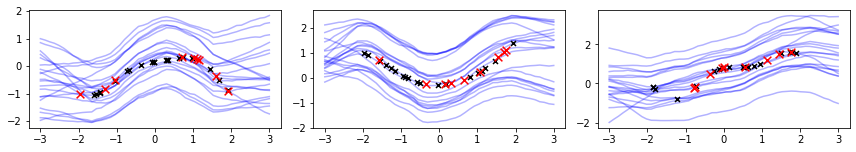

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 661/1000
Training        epoch 660: 1.948e+01
Validation      epoch 660: 3.872e+02


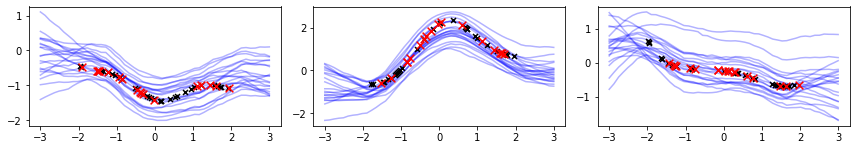

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 671/1000
Training        epoch 670: 1.442e+01
Validation      epoch 670: 1.003e+02


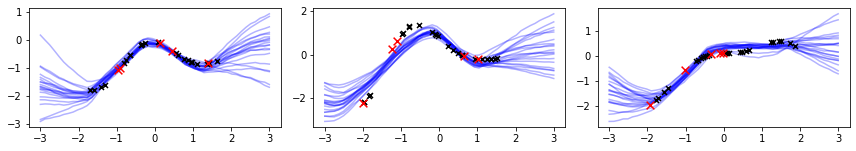

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 681/1000
Training        epoch 680: 1.950e+01
Validation      epoch 680: 3.112e+02


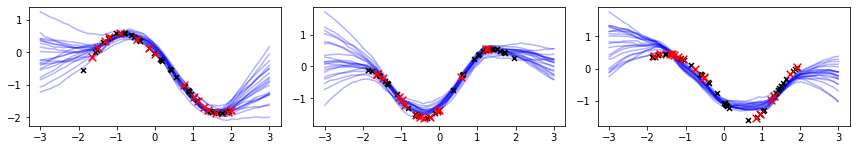

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 691/1000
Training        epoch 690: 1.655e+01
Validation      epoch 690: 4.281e+02


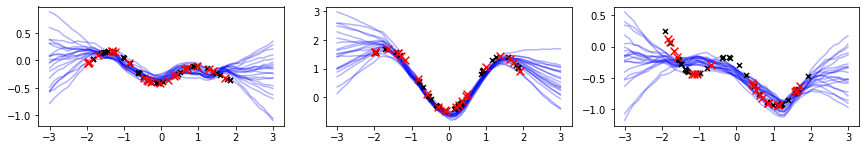

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 701/1000
Training        epoch 700: 1.580e+01
Validation      epoch 700: 2.433e+02


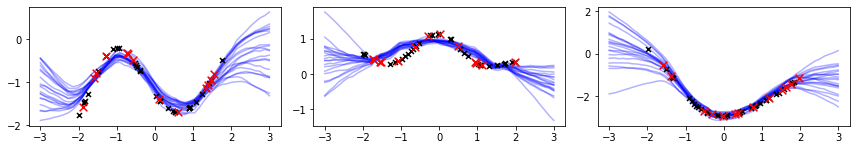

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 711/1000
Training        epoch 710: 1.508e+01
Validation      epoch 710: 5.485e+02


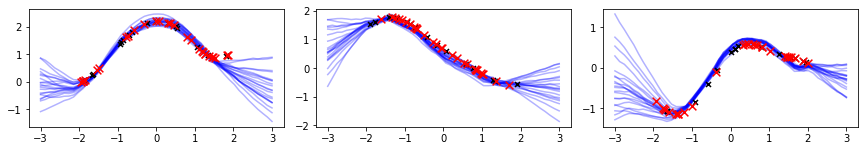

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 721/1000
Training        epoch 720: 1.264e+01
Validation      epoch 720: 7.416e+02


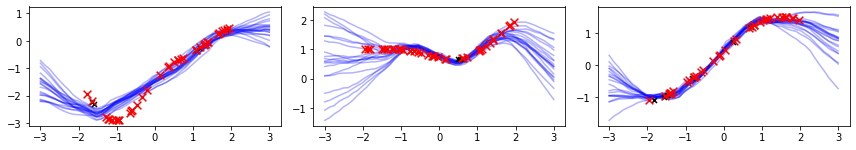

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 731/1000
Training        epoch 730: 1.639e+01
Validation      epoch 730: 1.296e+02


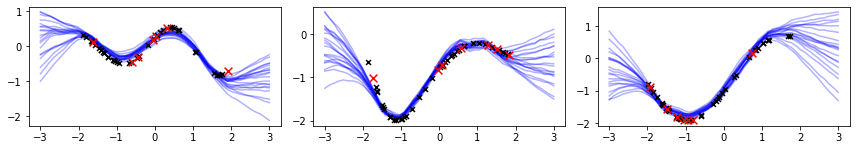

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 741/1000
Training        epoch 740: 1.503e+01
Validation      epoch 740: 9.321e+02


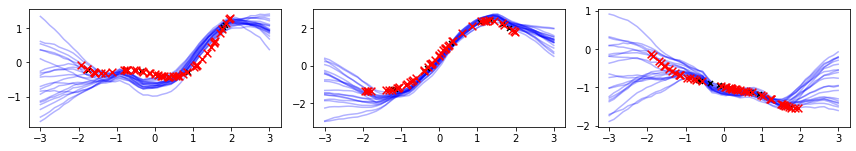

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 751/1000
Training        epoch 750: 1.453e+01
Validation      epoch 750: 7.749e+02


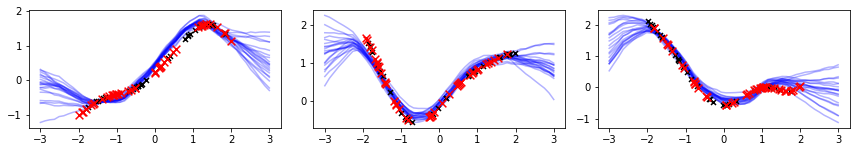

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 761/1000
Training        epoch 760: 1.494e+01
Validation      epoch 760: 7.859e+02


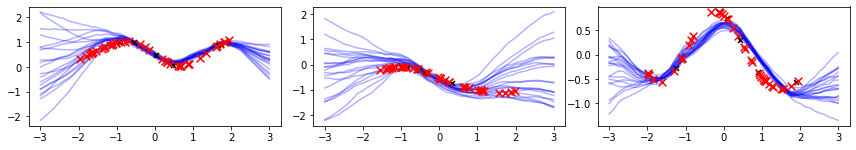

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 771/1000
Training        epoch 770: 1.686e+01
Validation      epoch 770: 4.668e+02


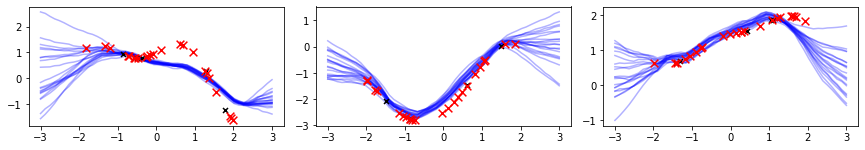

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 781/1000
Training        epoch 780: 1.654e+01
Validation      epoch 780: 5.012e+02


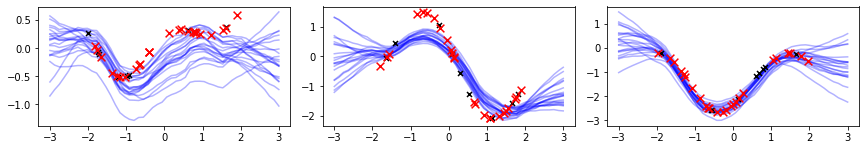

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 791/1000
Training        epoch 790: 1.714e+01
Validation      epoch 790: 6.263e+02


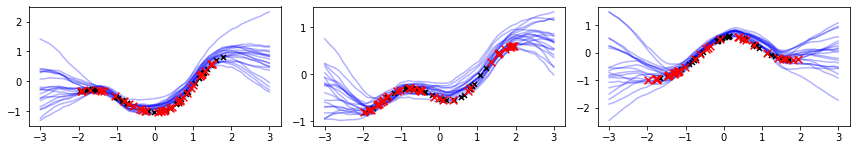

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 801/1000
Training        epoch 800: 1.606e+01
Validation      epoch 800: 7.871e+02


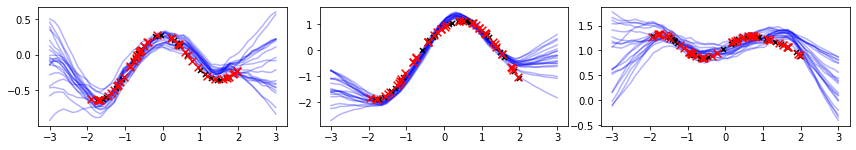

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 811/1000
Training        epoch 810: 1.589e+01
Validation      epoch 810: 6.695e+02


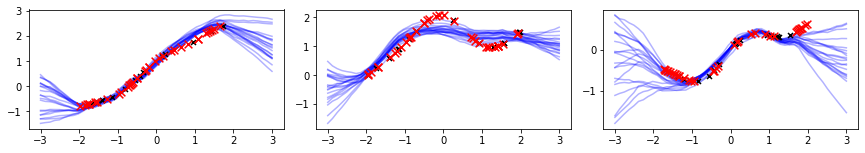

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 821/1000
Training        epoch 820: 1.383e+01
Validation      epoch 820: 3.339e+02


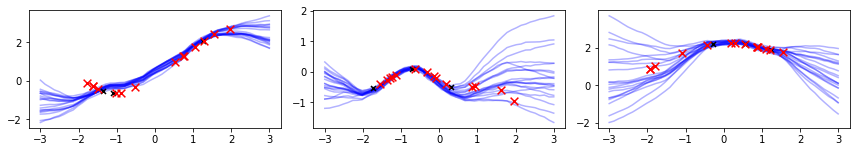

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 831/1000
Training        epoch 830: 1.270e+01
Validation      epoch 830: 2.171e+02


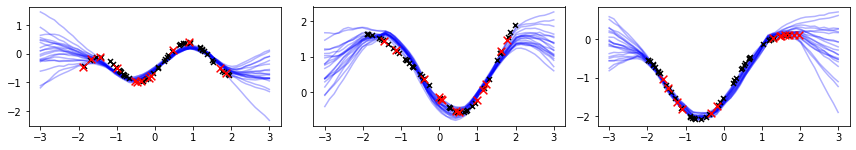

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 841/1000
Training        epoch 840: 1.331e+01
Validation      epoch 840: 2.232e+02


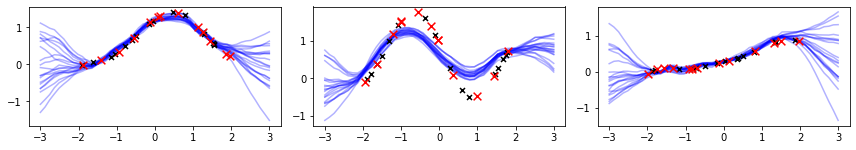

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 851/1000
Training        epoch 850: 1.558e+01
Validation      epoch 850: 3.698e+02


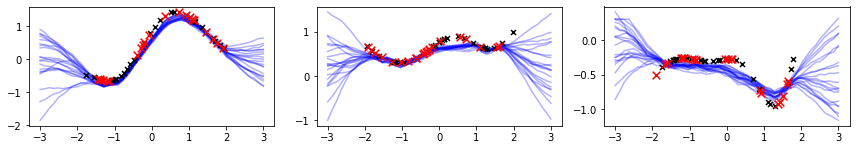

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 861/1000
Training        epoch 860: 1.659e+01
Validation      epoch 860: 6.585e+02


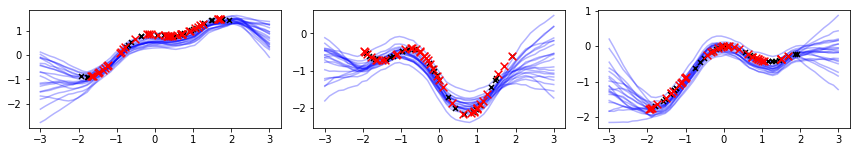

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 871/1000
Training        epoch 870: 1.237e+01
Validation      epoch 870: 7.756e+02


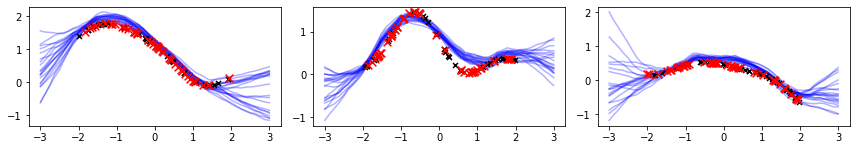

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 881/1000
Training        epoch 880: 1.335e+01
Validation      epoch 880: 6.394e+01


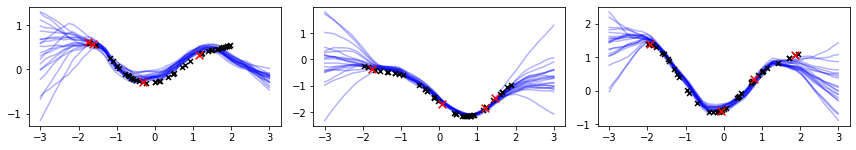

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 891/1000
Training        epoch 890: 1.416e+01
Validation      epoch 890: 4.330e+02


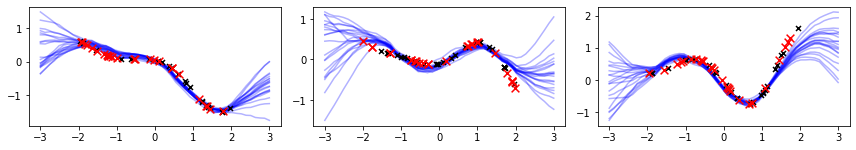

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 901/1000
Training        epoch 900: 1.315e+01
Validation      epoch 900: 7.282e+01


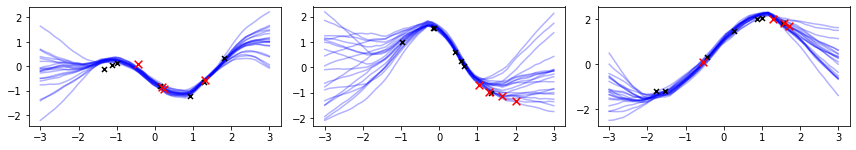

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 911/1000
Training        epoch 910: 1.305e+01
Validation      epoch 910: 2.319e+02


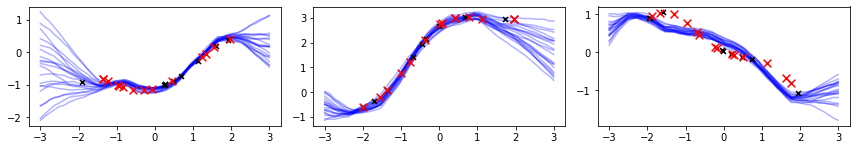

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 921/1000
Training        epoch 920: 1.360e+01
Validation      epoch 920: 2.455e+02


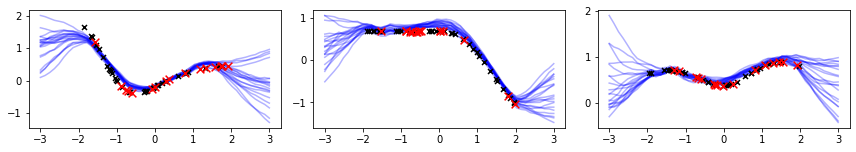

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 931/1000
Training        epoch 930: 1.371e+01
Validation      epoch 930: 7.782e+02


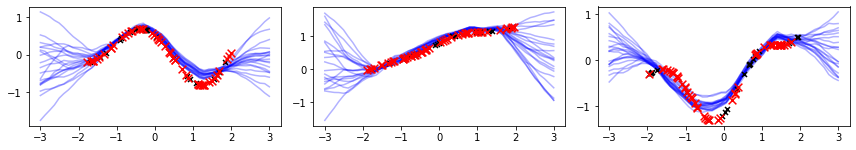

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 941/1000
Training        epoch 940: 1.310e+01
Validation      epoch 940: 3.075e+02


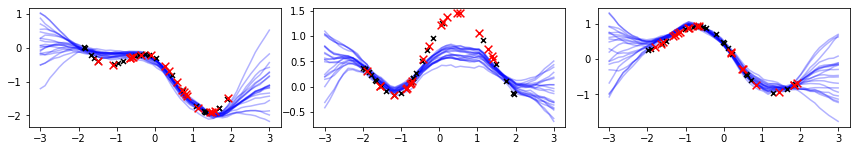

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 951/1000
Training        epoch 950: 1.135e+01
Validation      epoch 950: 1.365e+02


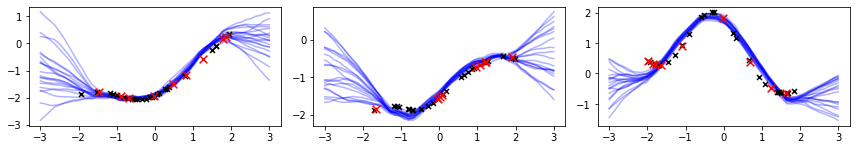

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 961/1000
Training        epoch 960: 1.310e+01
Validation      epoch 960: 2.273e+02


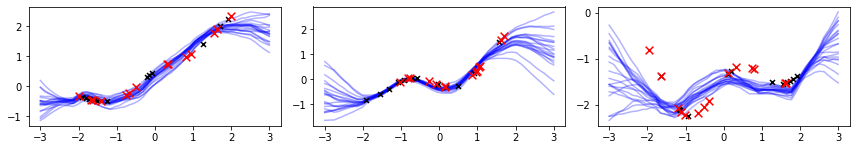

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 971/1000
Training        epoch 970: 1.343e+01
Validation      epoch 970: 1.402e+02


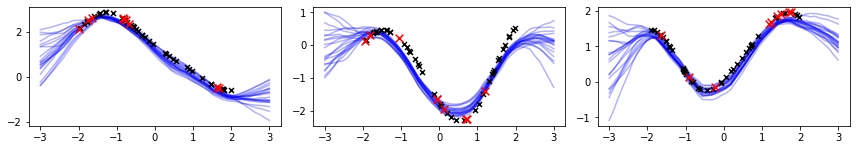

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 981/1000
Training        epoch 980: 1.272e+01
Validation      epoch 980: 1.769e+02


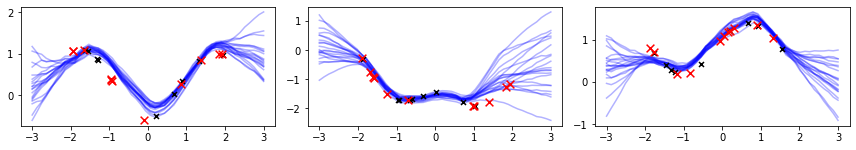

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch: 991/1000
Training        epoch 990: 1.039e+01
Validation      epoch 990: 1.946e+02


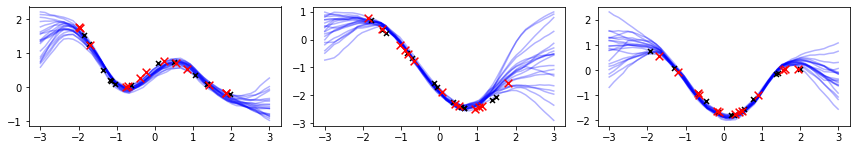

/Users/stratis/repos/kernelcnp/venv-kernelcnp/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [5]:
torch.set_default_tensor_type(torch.FloatTensor)

cov = InnerProdCov(num_basis_dim)
noise = AddHomoNoise()

model = StandardFullyConnectedTEGNP(covariance=cov, add_noise=noise)

opt = torch.optim.Adam(model.parameters(), learning_rate)

for epoch in range(epochs):

    # Compute training objective
    train_obj = train(gen, model, opt, report_freq=num_train_tasks)
    
    if epoch % int(1e1) == 0:
    
        print('\nEpoch: {}/{}'.format(epoch + 1, epochs))
        
        report_loss('Training', train_obj, f'epoch {epoch}')

        # Compute validation objective
        val_obj, task = validate(gen_val, model, report_freq=num_valid_tasks)
        report_loss('Validation', val_obj, f'epoch {epoch}')

        x_context = task['x_context'].float()
        y_context = task['y_context'].float()

        x_target = task['x_target'].float()
        y_target = task['y_target'].float()

        plt.figure(figsize=(12, 4))

        for i in range(3):

            xlin = torch.linspace(-3., 3., 50)[None, :, None]

            plt.subplot(2, 3, i+1)
            plt.scatter(x_context[i, :, 0], y_context[i, :, 0], marker='x', s=25, color='black', zorder=10, label='Context')
            plt.scatter(x_target[i, :, 0], y_target[i, :, 0], marker='x', s=60, color='red', zorder=10, label='Target')

            mean, cov, cov_plus_noise = model(x_context[i:i+1, :, :], y_context[i:i+1, :, :], xlin)

            x_plot = np.array(xlin)[0, :, 0]
            mean = mean.detach().cpu().float().numpy()[0, :, 0]
            cov = cov.detach().cpu().float().numpy()[0, :, :]
            cov_plus_noise = cov_plus_noise.detach().cpu().float().numpy()[0, :, :]

            cov = cov + 1e-4 * np.eye(cov.shape[0], dtype=np.float64)
            chol = np.linalg.cholesky(cov)

            for j in range(20):
                sample = mean + chol @ np.random.normal(size=(x_plot.shape[0],))
                plt.plot(x_plot, sample, color='blue', alpha=0.3)

        plt.tight_layout()
        plt.show()